One-paragraph abstract (150 words or less, in a Word file)  
Digital headshot (high-resolution JPG preferred)  
Letter of tax determination from your institution  
W-9 Form from your institution 

# Research Abstract 
Preoperative localization of adrenocorticotropic hormone (ACTH)-secreting pituitary microadenomas remains a diagnostic challenge. Although pituitary MRI is the most common diagnostic study for pituitary tumors, negative MRIs occur in up to 50% of patients with biochemically confirmed Cushing’s disease and surgical failure approaches 50% in this group. Inferior petrosal sinus sampling (IPSS) was developed to lateralize ACTH-secreting adenomas. Unfortunately, IPSS is invasive and has a lateralization accuracy of 69%.There is a critical need to improve preoperative localization in order to optimize the safety, accuracy, and efficacy of surgical treatment. We hypothesize that state-of-the-art deep convolutional neural network models trained on curated institutional pituitary adenoma MRI series and public brain MRI datasets will allow for automated detection and localization of ACTH-secreting microadenomas. In addition to the clinical contribution, we aim to contribute a methodological template for automated detection, localization, and interpretation of complex skull base lesions.


Q: tweak research abstract for ABTA?

# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

for folder_name, (obj_path, nii_path) in list(train_data_dict.items())[:5]:
    print(f"Folder {folder_name}: ", "\n\t", obj_path, "\n\t", nii_path, "\n")

Train data folders: [range(50002, 50017), range(50019, 50020), range(50022, 50049), range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)

Folder 50049:  
	 ./train_data/train_data/50049/Segmentation.obj 
	 ./train_data/train_data/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545/ABIDE_50049_MRI_MP-RAGE_br_raw_20120830165423769_S164545_I328548.nii 

Folder 50455:  
	 ./train_data/train_data/50455/Segmentation.obj 
	 ./train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii 

Folder 50458:  
	 ./train_data/train_data/50458/Segmentation.obj 
	 ./train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii 

Folder 50461:  
	 ./train_data/train_data/50461/Segmentation.obj 
	 ./train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I32

### Load Atlas

Preproccessing makes isotropic.

In [4]:
# isotropic preprocessing param
iso_spacing      = (1,1,1)
iso_interpolator = sitk.sitkLinear # sitk.sitkBSline

In [5]:
# set atlas MRs (10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment)
# takes 2 minutes to resample iso spacing
atlas_range, ras_adj = range(50455, 50464), True
atlas_folders = [str(i) for i in atlas_range]
atlas_objs, atlas_mask_objs = zip(*[folder2objs(atlas_folder, train_data_dict, iso_spacing, iso_interpolator, ras_adj) \
                               for atlas_folder in atlas_folders])

In [6]:
atlas_mask_arrs   = [sitk2np(o) for o in atlas_mask_objs]
atlas_bbox_coords = [mask2bbox(arr) for arr in atlas_mask_arrs]

In [48]:
from pandas import DataFrame

def is_bbox(arr, imin, imax, jmin, jmax, kmin, kmax):
    return np.all(arr[imin:imax, jmin:jmax, kmin:kmax])

def get_info_df_row(folder, obj, mask_arr, bbox_coord):
    print(bbox_coord)
    shape0, shape1, shape2             = obj.GetSize()
    imin, imax, jmin, jmax, kmin, kmax = bbox_coord
    roi_size0, roi_size1, roi_size2    = imax-imin, jmax-jmin, kmax-kmin
    is_bbox_bool                       = is_bbox(mask_arr, *bbox_coord)
    
    return {"folder": folder, \
            "shape0": shape0, "shape1": shape1, "shape2": shape2, \
            "roi_size0": roi_size0, "roi_size1": roi_size1, "roi_size2": roi_size2, \
            "is_bbox": is_bbox_bool,
            "imin": imin, "imax":imax, \
            "jmin":jmin, "jmax": jmax, \
            "kmin": kmin, "kmax": kmax}
    
def get_info_df(folders, objs, mask_arrs, bbox_coords):
    return DataFrame([get_info_df_row(folder, obj, mask_arr, bbox) \
                      for folder, obj, mask_arr, bbox in zip(folders, objs, mask_arrs, bbox_coords)])

In [34]:
atlas_info_df = get_info_df(atlas_range, atlas_objs, atlas_mask_arrs, atlas_bbox_coords)
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,192,240,256,33,28,17,False,78,111,114,142,103,120
1,50456,192,240,256,29,24,16,False,78,107,116,140,120,136
2,50457,192,240,256,28,25,16,False,80,108,115,140,122,138
3,50458,192,240,256,24,23,19,False,81,105,121,144,99,118
4,50459,192,240,256,32,24,17,False,82,114,111,135,105,122
5,50460,192,240,256,28,27,14,True,82,110,120,147,111,125
6,50461,192,240,256,27,21,16,True,83,110,116,137,121,137
7,50462,192,240,256,29,24,16,False,80,109,120,144,114,130
8,50463,192,240,256,29,26,18,False,80,109,119,145,114,132


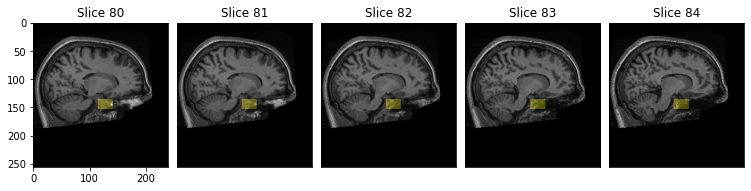

In [13]:
# Viz
index = 0
slice_range = lrange(80,85)

viz_axis(sitk2np(atlas_objs[index]), \
        bin_mask_arr = atlas_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [1, 5], hspace=0.3, fig_mult=2)

### Load Input

Samir folders: range(50002, 50017), range(50019, 50020), range(50022, 50049)

In [14]:
# isotropic preprocessing param
iso_spacing      = (1,1,1)
iso_interpolator = sitk.sitkLinear # sitk.sitkBSline

In [35]:
# set input MRs (Samir's, no RAS adj needed for mask)
input_range, ras_adj = range(50002, 50017), False
input_folders = [str(i) for i in input_range]
input_objs, input_mask_objs = zip(*[folder2objs(input_folder, train_data_dict, iso_spacing, iso_interpolator, ras_adj) \
                               for input_folder in input_folders])

In [37]:
input_mask_arrs   = [sitk2np(o) for o in input_mask_objs]
input_bbox_coords = [mask2bbox(arr) for arr in input_mask_arrs]

In [42]:
index = 0
np.array_equal(atlas_mask_arrs[index], input_mask_arrs[index])

False

In [44]:
mask2bbox(atlas_mask_arrs[index])

(78, 111, 114, 142, 103, 120)

In [46]:
mask2bbox(input_mask_arrs[index])

(78, 115, 142, 170, 107, 127)

In [47]:
input_bbox_coords

[(78, 115, 142, 170, 107, 127),
 (80, 109, 146, 168, 112, 130),
 (76, 111, 133, 159, 91, 116),
 (77, 109, 132, 156, 99, 117),
 (80, 110, 133, 157, 105, 123),
 (76, 107, 146, 171, 106, 125),
 (77, 107, 139, 161, 97, 114),
 (72, 110, 134, 157, 108, 126),
 (88, 112, 137, 157, 108, 125),
 (77, 106, 138, 161, 116, 137),
 (79, 101, 124, 146, 126, 146),
 (75, 106, 137, 154, 112, 132),
 (83, 111, 132, 155, 96, 112),
 (81, 109, 122, 148, 109, 129),
 (79, 103, 142, 162, 97, 117)]

In [49]:
input_info_df = get_info_df(input_range, input_objs, input_mask_arrs, input_bbox_coords)
input_info_df

(78, 115, 142, 170, 107, 127)
(80, 109, 146, 168, 112, 130)
(76, 111, 133, 159, 91, 116)
(77, 109, 132, 156, 99, 117)
(80, 110, 133, 157, 105, 123)
(76, 107, 146, 171, 106, 125)
(77, 107, 139, 161, 97, 114)
(72, 110, 134, 157, 108, 126)
(88, 112, 137, 157, 108, 125)
(77, 106, 138, 161, 116, 137)
(79, 101, 124, 146, 126, 146)
(75, 106, 137, 154, 112, 132)
(83, 111, 132, 155, 96, 112)
(81, 109, 122, 148, 109, 129)
(79, 103, 142, 162, 97, 117)


,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50002,185,269,269,37,28,20,False,78,115,142,170,107,127
1,50003,185,269,269,29,22,18,False,80,109,146,168,112,130
2,50004,185,269,269,35,26,25,False,76,111,133,159,91,116
3,50005,185,269,269,32,24,18,False,77,109,132,156,99,117
4,50006,185,269,269,30,24,18,False,80,110,133,157,105,123
5,50007,185,269,269,31,25,19,False,76,107,146,171,106,125
6,50008,185,269,269,30,22,17,False,77,107,139,161,97,114
7,50009,185,269,269,38,23,18,False,72,110,134,157,108,126
8,50010,185,269,269,24,20,17,False,88,112,137,157,108,125
9,50011,185,269,269,29,23,21,False,77,106,138,161,116,137


In [38]:
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,192,240,256,33,28,17,False,78,111,114,142,103,120
1,50456,192,240,256,29,24,16,False,78,107,116,140,120,136
2,50457,192,240,256,28,25,16,False,80,108,115,140,122,138
3,50458,192,240,256,24,23,19,False,81,105,121,144,99,118
4,50459,192,240,256,32,24,17,False,82,114,111,135,105,122
5,50460,192,240,256,28,27,14,True,82,110,120,147,111,125
6,50461,192,240,256,27,21,16,True,83,110,116,137,121,137
7,50462,192,240,256,29,24,16,False,80,109,120,144,114,130
8,50463,192,240,256,29,26,18,False,80,109,119,145,114,132


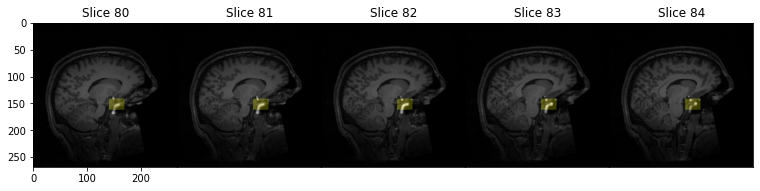

In [50]:
# Viz
index = 0
slice_range = lrange(80,85)

viz_axis(sitk2np(input_objs[index]), \
        bin_mask_arr = input_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [1, 5], hspace=0.3, fig_mult=2)

# Elastix Registration

## Rigid Alignment

- Rigid: "rigid body, which can translate and rotate, but cannot be
scaled/stretched."

- Similarity: "translate, rotate, and scale isotropically."

- Affine: "translated, rotated, scaled,
and sheared."

### ROI Mapping
Elastix convention: Resampling $moving \to fixed$ image involves a transformation $T: fixed \to moving$. $T$ maps coordinates in the fixed image domain to the corresponding coordinates in the moving image. Resampling a moving image onto the fixed image coordinate system involves:
1. Apply $T$ to fixed image voxel coordinates $x$ to get corresponding coordinates $y$ in the moving domain: $y = T(x) \in I_M$.
2. Estimate the voxel intensities $v$ at the moving image coordinates $y \in I_m$ via (linear) interpolation from nearby moving image voxel intensities.
3. Set the voxel intensities $v$ at the fixed image coordinates $x \in I_F$ to the above moving image voxel intensities.

Source: 5.0.1 Elastix Manual

In [51]:
#selx.SetLogToConsole(False)

def align_and_tfm(fixed_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    #elastixImageFilter.SetLogToConsole(False)
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    #transformixImageFilter.SetLogToConsole(False)
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

# Rigid only

In [87]:
import time

def get_dice_scores(input_obj, input_mask_arr, atlas_objs = atlas_objs, atlas_mask_objs = atlas_mask_objs):
    dice_scores = {}
    n_votes = len(atlas_objs)
    print(f"N={n_votes} atlases in the vote.")
    
    for i in range(n_votes):
        print(f"Getting pred for atlas {i}:")
        
        start = time.time()
        pred_mask_arr = sitk2np(align_and_tfm(input_obj, atlas_objs[i], atlas_mask_objs[i], \
                                              param_files = ["affine.txt"])).astype(bool)
        end = time.time()
        print(f"{end - start:.0f} sec.")
        # compute dice
        dice_scores[f"dice{i}"] = compute_dice_coefficient(input_mask_arr, pred_mask_arr)
    
        # add atlas vote
        if i == 0: vote_pred_mask_arr = pred_mask_arr.astype(np.uint8)
        else: vote_pred_mask_arr += pred_mask_arr.astype(np.uint8)
    
    # get avg dice score
    dice_scores[f"dice_avg"] = np.mean(list(dice_scores.values()))
    
    # get vote
    print(f"Getting vote dice")
    vote_pred_mask_arr = (vote_pred_mask_arr >= n_votes/2).astype(bool)
    dice_scores[f"dice_vote_all"] = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr)
    
    print(dice_scores)
    return dice_scores

In [53]:
dice_scores0 = get_dice_scores(input_objs[0], input_mask_arrs[0], atlas_objs[:2], atlas_mask_objs[:2])

N=2 atlases in the vote.
Getting pred for atlas 0:
Getting pred for atlas 1:
Getting vote dice


In [54]:
dice_scores0

{'dice0': 0.6036217303822937,
 'dice1': 0.6601097030452052,
 'dice_vote1': 0.6879893768029671}

In [83]:
dice_scores0 = get_dice_scores(input_objs[0], input_mask_arrs[0], atlas_objs, atlas_mask_objs)

N=9 atlases in the vote.
Getting pred for atlas 0:
10 sec.
Getting pred for atlas 1:
11 sec.
Getting pred for atlas 2:
11 sec.
Getting pred for atlas 3:
12 sec.
Getting pred for atlas 4:
12 sec.
Getting pred for atlas 5:
11 sec.
Getting pred for atlas 6:
12 sec.
Getting pred for atlas 7:
12 sec.
Getting pred for atlas 8:
12 sec.
Getting vote dice
{'dice0': 0.6036217303822937, 'dice1': 0.6601097030452052, 'dice2': 0.7483846548974019, 'dice3': 0.6285481461360858, 'dice4': 0.4891092083521106, 'dice5': 0.08377450094259226, 'dice6': 0.4019090547527509, 'dice7': 0.4950745403782332, 'dice8': 0.6552589097230845, 'dice_vote8': 0.5656965546757972}


In [84]:
dice_scores0

{'dice0': 0.6036217303822937,
 'dice1': 0.6601097030452052,
 'dice2': 0.7483846548974019,
 'dice3': 0.6285481461360858,
 'dice4': 0.4891092083521106,
 'dice5': 0.08377450094259226,
 'dice6': 0.4019090547527509,
 'dice7': 0.4950745403782332,
 'dice8': 0.6552589097230845,
 'dice_vote8': 0.5656965546757972}

In [88]:
input_df = DataFrame(get_dice_scores(input_obj, gt_mask, atlas_objs, atlas_mask_objs) \
                     for input_obj, gt_mask in zip(input_objs, input_mask_arrs))

N=9 atlases in the vote.
Getting pred for atlas 0:
10 sec.
Getting pred for atlas 1:
11 sec.
Getting pred for atlas 2:
11 sec.
Getting pred for atlas 3:
12 sec.
Getting pred for atlas 4:
11 sec.
Getting pred for atlas 5:
11 sec.
Getting pred for atlas 6:
11 sec.
Getting pred for atlas 7:
11 sec.
Getting pred for atlas 8:
11 sec.
Getting vote dice
{'dice0': 0.6036217303822937, 'dice1': 0.6601097030452052, 'dice2': 0.7483846548974019, 'dice3': 0.6285481461360858, 'dice4': 0.4891092083521106, 'dice5': 0.08377450094259226, 'dice6': 0.4019090547527509, 'dice7': 0.4950745403782332, 'dice8': 0.6552589097230845, 'dice_avg': 0.5295322720677509, 'dice_vote_all': 0.5656965546757972}
N=9 atlases in the vote.
Getting pred for atlas 0:
11 sec.
Getting pred for atlas 1:
11 sec.
Getting pred for atlas 2:
11 sec.
Getting pred for atlas 3:
11 sec.
Getting pred for atlas 4:
12 sec.
Getting pred for atlas 5:
11 sec.
Getting pred for atlas 6:
11 sec.
Getting pred for atlas 7:
11 sec.
Getting pred for atlas

11 sec.
Getting pred for atlas 5:
11 sec.
Getting pred for atlas 6:
11 sec.
Getting pred for atlas 7:
11 sec.
Getting pred for atlas 8:
11 sec.
Getting vote dice
{'dice0': 0.5356423681031011, 'dice1': 0.7719803718543196, 'dice2': 0.8017106963068561, 'dice3': 0.5749819754866619, 'dice4': 0.6470831609433182, 'dice5': 0.44239013933547694, 'dice6': 0.6437212624436409, 'dice7': 0.6454155355109904, 'dice8': 0.7781859743652543, 'dice_avg': 0.6490123871499577, 'dice_vote_all': 0.6996640537513997}
N=9 atlases in the vote.
Getting pred for atlas 0:
11 sec.
Getting pred for atlas 1:
11 sec.
Getting pred for atlas 2:
11 sec.
Getting pred for atlas 3:
11 sec.
Getting pred for atlas 4:
12 sec.
Getting pred for atlas 5:
11 sec.
Getting pred for atlas 6:
12 sec.
Getting pred for atlas 7:
11 sec.
Getting pred for atlas 8:
12 sec.
Getting vote dice
{'dice0': 0.41957166392092254, 'dice1': 0.2764501598872193, 'dice2': 0.39910251984811873, 'dice3': 0.22372126986334712, 'dice4': 0.2498803255146003, 'dice5':

In [89]:
input_df

,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.603622,0.660110,0.748385,0.628548,0.489109,0.083775,0.401909,0.495075,0.655259,0.529532,0.565697
1,0.195292,0.561120,0.538386,0.383455,0.391878,0.000000,0.238872,0.345614,0.543964,0.355398,0.413907
2,0.641915,0.675103,0.627414,0.646111,0.717821,0.242456,0.627793,0.689190,0.757059,0.624985,0.671621
3,0.464937,0.626501,0.634360,0.472981,0.732550,0.200442,0.642480,0.512801,0.691672,0.553192,0.569036
4,0.422820,0.650574,0.645882,0.497009,0.740136,0.492969,0.710923,0.549273,0.691250,0.600093,0.600839
5,0.628837,0.757693,0.833282,0.701292,0.508365,0.291592,0.528356,0.664118,0.832541,0.638453,0.648406
6,0.541478,0.836605,0.778124,0.643976,0.587936,0.000000,0.376193,0.599007,0.776095,0.571046,0.656439
7,0.338278,0.347705,0.326452,0.182481,0.425930,0.000000,0.019207,0.384659,0.624911,0.294403,0.328907
8,0.270078,0.330175,0.444139,0.274030,0.566529,0.000000,0.116063,0.153091,0.473689,0.291977,0.309170
9,0.000000,0.625533,0.659966,0.522633,0.271171,0.000000,0.318842,0.510474,0.629246,0.393096,0.493659


In [90]:
input_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50002,185,269,269,37,28,20,False,78,115,142,170,107,127
1,50003,185,269,269,29,22,18,False,80,109,146,168,112,130
2,50004,185,269,269,35,26,25,False,76,111,133,159,91,116
3,50005,185,269,269,32,24,18,False,77,109,132,156,99,117
4,50006,185,269,269,30,24,18,False,80,110,133,157,105,123
5,50007,185,269,269,31,25,19,False,76,107,146,171,106,125
6,50008,185,269,269,30,22,17,False,77,107,139,161,97,114
7,50009,185,269,269,38,23,18,False,72,110,134,157,108,126
8,50010,185,269,269,24,20,17,False,88,112,137,157,108,125
9,50011,185,269,269,29,23,21,False,77,106,138,161,116,137


In [93]:
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,192,240,256,33,28,17,False,78,111,114,142,103,120
1,50456,192,240,256,29,24,16,False,78,107,116,140,120,136
2,50457,192,240,256,28,25,16,False,80,108,115,140,122,138
3,50458,192,240,256,24,23,19,False,81,105,121,144,99,118
4,50459,192,240,256,32,24,17,False,82,114,111,135,105,122
5,50460,192,240,256,28,27,14,True,82,110,120,147,111,125
6,50461,192,240,256,27,21,16,True,83,110,116,137,121,137
7,50462,192,240,256,29,24,16,False,80,109,120,144,114,130
8,50463,192,240,256,29,26,18,False,80,109,119,145,114,132


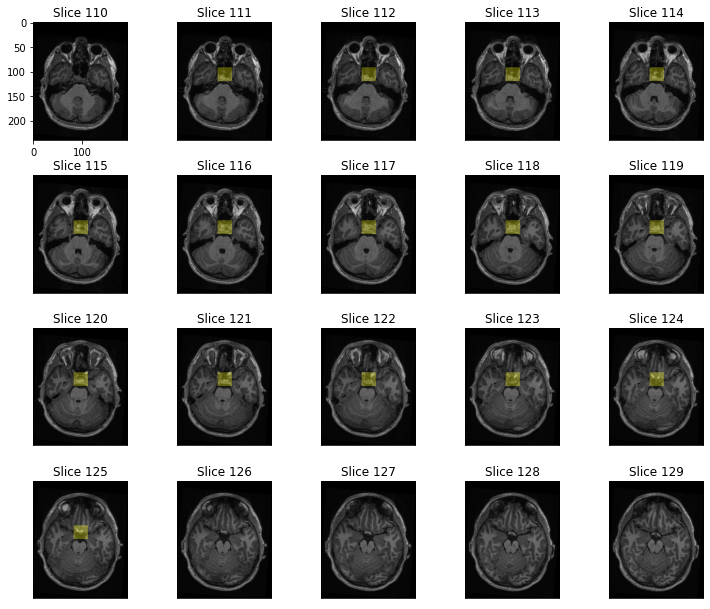

In [96]:
# Viz
index = 5
slice_range = lrange(110,130)

viz_axis(sitk2np(atlas_objs[index]), \
        bin_mask_arr = atlas_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=2, \
        axis_fn = np.rot90, \
        grid = [4,5], hspace=0.3, fig_mult=2)

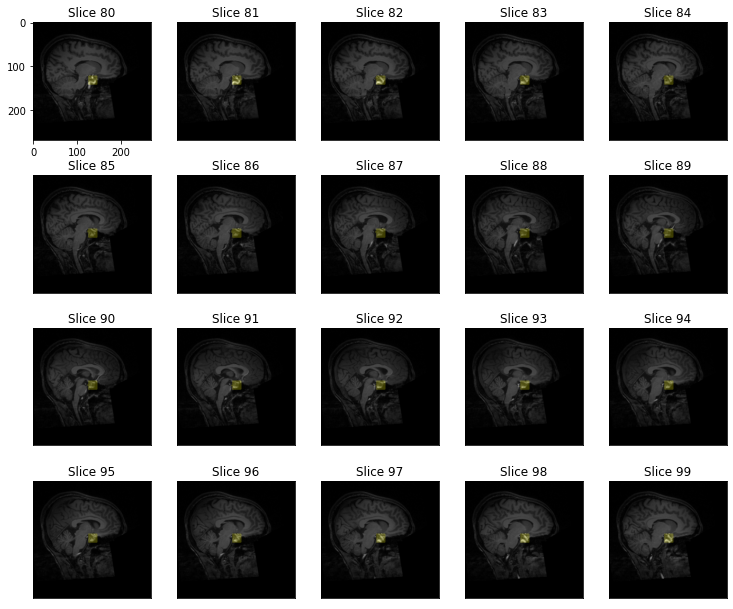

In [97]:
# Viz
index = 10
slice_range = lrange(80,100)

viz_axis(sitk2np(input_objs[index]), \
        bin_mask_arr = input_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [4, 5], hspace=0.3, fig_mult=2)

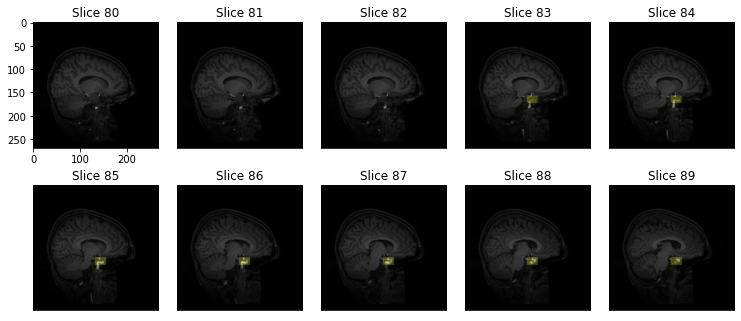

In [92]:
# Viz
index = 12
slice_range = lrange(80,90)

viz_axis(sitk2np(input_objs[index]), \
        bin_mask_arr = input_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [44]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_objs = [align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"]) for
                 atlas_obj, atlas_mask_obj in zip(atlas_objs, atlas_mask_objs)]

NameError: name 'input_obj' is not defined

In [ ]:
# Evaluate predicted input ROI
gt_mask_arr = input_mask_arr

#gt_mask_arr   = sitk2np(gt_mask_obj).astype(bool)
pred_mask_arr = sitk2np(pred_mask_obj).astype(bool)

In [ ]:
dice     = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)
coverage = compute_coverage_coefficient(gt_mask_arr, pred_mask_arr)
bbox_coords = mask2bbox(pred_mask_arr)

In [ ]:
print({"dice": f"{dice:0.2f}", "coverage": f"{coverage:0.2f}"})
print_bbox(*bbox_coords)

In [ ]:
print("Affine: ", bbox_coords)
print("GT: ", input_bbox_coords)

In [ ]:
# Viz affine
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
bspline_pred_mask_obj = align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"])

In [ ]:
# Evaluate predicted input ROI
bspline_pred_mask_arr = sitk2np(bspline_pred_mask_obj).astype(bool)

bspline_dice     = compute_dice_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_coverage = compute_coverage_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_bbox_coords = mask2bbox(bspline_pred_mask_arr)

print({"dice": f"{bspline_dice:0.2f}", "coverage": f"{bspline_coverage:0.2f}"})
print_bbox(*bspline_bbox_coords)

In [ ]:
print("Affine: ", bbox_coords)
print("+Bspline: ", bspline_bbox_coords)
print("GT: ", input_bbox_coords)

In [ ]:
print("Ground Truth GT")
print_bbox(*input_bbox_coords)

print("Affine only")
print_bbox(*bbox_coords)

print("+Bspline")
print_bbox(*bspline_bbox_coords)

In [ ]:
# Viz affine + bspline
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = [77,78,79, 80] + [109,110,111,112]

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=55,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

# Affine non-whole brain

Focus alignment on generated input ROI

In [ ]:
# pad slices by 5, crop extra bbox by 10vox x 10vox

In [ ]:
def crop_extra_mask(bin_mask_arr, crop_coords, slice_pad, vox_pad, fixed_axis=06):
    imin, imax, jmin, jmax, kmin, kmax = crop_coords
    if fixed_axis == 0:   
        jmin -= pad; jmax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[:, jmin:jmax, kmin:kmax]

    elif fixed_axis == 1: 
        imin -= pad; imax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, :, kmin:kmax]

    else:
        imin -= pad; imax += pad; jmin -= pad; jmax += pad;
        np_arr = np_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, jmin:jmax, :]

In [ ]:
pred_mask_obj

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_obj = align_focused(input_obj, pred_roi, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"])

In [ ]:
def align_focused(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set masks
    elastixImageFilter.SetFixedMask(fixed_mask_obj)
    elastixImageFilter.SetMovingMask(moving_mask_obj)
    
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

### Viz Mapped ROI

In [ ]:
print(transformed_input_mask_arr.shape)

transformed_input_bbox_coords = mask2bbox(transformed_input_mask_arr)
print_bbox(*transformed_input_bbox_coords)

Compare bounding boxes

In [ ]:
print(f"Original Moving Mask"), print_bbox(*input_bbox_coords);
print(f"ROI contains {np.count_nonzero(input_mask_arr)} elements.", "\n");

print(f"Target Fixed Mask"), print_bbox(*atlas_bbox_coords);
print(f"ROI contains {np.count_nonzero(atlas_mask_arr)} elements.", "\n");

print(f"Transformed Moving Mask"), print_bbox(*transformed_input_bbox_coords);
print(f"ROI contains {np.count_nonzero(transformed_input_mask_arr)} elements.", "\n");

In [ ]:
viz_axis(input_mask_arr, bin_mask_arr=transformed_input_mask_arr, 
        slices=lrange(76, 80) + lrange(110,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

### Coronal

In [ ]:
sitk2np(iso_atlas_obj).shape

In [ ]:
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(120, 126), atlas_axis=1, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

## Sagittal

In [ ]:
#cmap1 = [white, yellow]; cmap2 = [white, blue]
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(76, 80) + lrange(104,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 4], hspace=0.3, fig_mult=2, cmap0="gray")

# Old

In [ ]:
def affine_align(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, param_file = "AffineParamFile.txt"):
    
    # map moving => fixed (the transform is fixed => moving)
    #parameterMap = sitk.GetDefaultParameterMap('affine')
    parameterMap  = sitk.ReadParameterFile(param_file)
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # focus on registering moving mask ROI
    #elastixImageFilter.SetMovingMask(moving_mask_obj)
    #parameterMap["ImageSampler"] = ["RandomSparseMask"]
   
    # print param map
    sitk.PrintParameterMap(parameterMap)
    
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()

    transformed_moving_obj  = elastixImageFilter.GetResultImage()
    transformedParameterMap = elastixImageFilter.GetTransformParameterMap()[0]
    
    # Binary mask => nearest neighbor
    transformedParameterMap["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    
    # map ROI of moving => fixed
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformedParameterMap)
    transformixImageFilter.SetMovingImage(moving_mask_obj)
    transformixImageFilter.Execute()
    
    transformed_moving_mask_obj = transformixImageFilter.GetResultImage()

    # evaluate: dice, coverage
    fixed_mask_arr              = sitk2np(fixed_mask_obj).astype(bool)
    transformed_moving_mask_arr = sitk2np(transformed_moving_mask_obj).astype(bool)

    dice     = compute_dice_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    coverage = compute_coverage_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    
    # save bounding box coords
    bbox_coords = mask2bbox(transformed_moving_mask_arr)
        
    return dice, coverage, bbox_coords, transformed_moving_obj, transformed_moving_mask_arr

In [ ]:
dice, coverage, bbox_coords, transformed_input_obj, transformed_input_mask_arr = affine_align(atlas_obj, atlas_mask_obj, input_obj, input_mask_obj)

In [ ]:
print(f"Dice: {dice}. Coverage {coverage}.")
print_bbox(*bbox_coords)